## Angle-conditional diffusion model training on monkey data
This notebook trains a LDNS diffusion model conditioned on behavior angle. It follows the same training procedure as the unconditional diffusion model, but with the addition of a conditioning vector based on the behavior angle. Finally, it plots trajectories that are decoded from spikes that are conditionally generated based on angles.

In [1]:
%load_ext autoreload
%autoreload 2

# append parent directory to path (../notebooks -> ..)
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

import accelerate
import lovely_tensors as lt
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import yaml
from diffusers.optimization import get_scheduler
from omegaconf import OmegaConf
from tqdm.auto import tqdm

from ldns.networks import AutoEncoder, CountWrapper
from ldns.utils.plotting_utils import *
from diffusers.training_utils import EMAModel
from diffusers.schedulers import DDPMScheduler

lt.monkey_patch()
matplotlib.rc_file("matplotlibrc")  # mackelab plotting style
import logging  # for supressing font warnings in matplotlib

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)


In [2]:
## load config and model path

cfg_ae = OmegaConf.load("conf/autoencoder-monkey_z=16.yaml")

cfg_yaml = """
denoiser_model:
  C_in: 16
  C: 256
  num_blocks: 6
  bidirectional: True
  condition_dim: 2 # behavior angle [sin, cos]
  num_train_timesteps: 1000
training:
  lr: 0.001
  weight_decay: 0.0
  num_epochs: 2000
  num_warmup_epochs: 50
  batch_size: 512
  random_seed: 42
  precision: "no"
exp_name: diffusion_monkey_angle_conditioned
"""

cfg = OmegaConf.create(yaml.safe_load(cfg_yaml))
cfg.dataset = cfg_ae.dataset


### Load autoencoder (with checkpoint) and autoencoder dataset


In [3]:
from ldns.data.monkey import get_monkey_dataloaders

# initialize autoencoder model
ae_model = AutoEncoder(
    C_in=cfg_ae.model.C_in,
    C=cfg_ae.model.C,
    C_latent=cfg_ae.model.C_latent,
    L=cfg_ae.dataset.signal_length,
    num_blocks=cfg_ae.model.num_blocks,
    num_blocks_decoder=cfg_ae.model.get("num_blocks_decoder", cfg_ae.model.num_blocks),
    num_lin_per_mlp=cfg_ae.model.get("num_lin_per_mlp", 2),  # default 2
    bidirectional=cfg_ae.model.get("bidirectional", True),
)

ae_model = CountWrapper(ae_model)

# load pretrained autoencoder
ae_model.load_state_dict(torch.load(f"exp/stored_models/{cfg_ae.exp_name}/model.pt"))

# set random seeds
torch.manual_seed(cfg.training.random_seed)
np.random.seed(cfg.training.random_seed)

# get dataloaders
train_dataloader, val_dataloader, test_dataloader = get_monkey_dataloaders(
    cfg_ae.dataset.task, cfg_ae.dataset.datapath, bin_width=5, batch_size=cfg_ae.training.batch_size
)

# setup accelerator
accelerator = accelerate.Accelerator(mixed_precision=cfg_ae.training.get("precision", "no"))

# prepare model and data for training
ae_model = accelerator.prepare(ae_model)

(
    train_dataloader,
    val_dataloader,
    test_dataloader,
) = accelerator.prepare(
    train_dataloader,
    val_dataloader,
    test_dataloader,
)


/tmp/ipykernel_126923/2776338074.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae_model.load_state_dict(torch.load(f"exp/stored_models/{cfg_ae.exp_name}/model.pt"))


Loaded train data dict from data/000128/sub-Jenkins/monkey_mc_maze_data_dict_train_split_5.pkl
Loaded val data dict from data/000128/sub-Jenkins/monkey_mc_maze_data_dict_val_split_5.pkl
Loaded train data dict from data/000128/sub-Jenkins/monkey_mc_maze_data_dict_train_split_5.pkl
Loaded val data dict from data/000128/sub-Jenkins/monkey_mc_maze_data_dict_val_split_5.pkl
Task: mc_maze, Bin width: 5 ms
Train: 2008, Val: 71, Test: 216


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [4]:
save_path = f"exp/{cfg.exp_name}"
os.makedirs(save_path, exist_ok=True)

In [5]:
(
    train_dataloader,
    val_dataloader,
    test_dataloader,
) = accelerator.prepare(
    train_dataloader,
    val_dataloader,
    test_dataloader,
)

In [6]:
# Create dataset containing behavior, behavior angle, spike dataset, latents from ae

from ldns.data.monkey import LatentMonkeyDataset

latent_dataset_train = LatentMonkeyDataset(train_dataloader, ae_model, clip=False)

latent_dataset_val = LatentMonkeyDataset(
    val_dataloader,
    ae_model,
    latent_means=latent_dataset_train.latent_means,
    latent_stds=latent_dataset_train.latent_stds,
    clip=False,
)

latent_dataset_test = LatentMonkeyDataset(
    test_dataloader,
    ae_model,
    latent_means=latent_dataset_train.latent_means,
    latent_stds=latent_dataset_train.latent_stds,
    clip=False,
)

Creating latent dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Creating latent dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Creating latent dataset:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
# set up dataloaders for diffusion training

train_latent_dataloader = torch.utils.data.DataLoader(
    latent_dataset_train,
    batch_size=cfg.training.batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_latent_dataloader = torch.utils.data.DataLoader(
    latent_dataset_val,
    batch_size=cfg.training.batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

test_latent_dataloader = torch.utils.data.DataLoader(
    latent_dataset_test,
    batch_size=cfg.training.batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

num_batches = len(train_latent_dataloader)

# check if signal length is power of 2
if cfg.dataset.signal_length & (cfg.dataset.signal_length - 1) != 0:
    cfg.training.precision = "no"  # torch.fft doesnt support half if L!=2^x

# prepare the denoiser model and dataset
(
    train_latent_dataloader,
    val_latent_dataloader,
    test_latent_dataloader,
) = accelerator.prepare(
    train_latent_dataloader,
    val_latent_dataloader,
    test_latent_dataloader,
)


In [9]:
## initialize (unconditional) denoiser
from ldns.networks.blocks import ConditionalDenoiser

denoiser = ConditionalDenoiser(
    C_in=cfg.denoiser_model.C_in,
    C=cfg.denoiser_model.C,
    L=cfg.dataset.signal_length,
    num_blocks=cfg.denoiser_model.num_blocks,
    bidirectional=cfg.denoiser_model.get("bidirectional", True),
    condition_dim=cfg.denoiser_model.condition_dim,
)

# initial values may be way off, scaling down the output layer makes training faster
denoiser.conv_out.weight.data = denoiser.conv_out.weight.data * 0.1
denoiser.conv_out.bias.data = denoiser.conv_out.bias.data * 0.1

scheduler = DDPMScheduler(
    num_train_timesteps=cfg.denoiser_model.num_train_timesteps, clip_sample=False, beta_schedule="linear"
)

optimizer = torch.optim.AdamW(denoiser.parameters(), lr=cfg.training.lr)  # default wd=0.01 for now


num_batches = len(train_latent_dataloader)
lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=num_batches * cfg.training.num_warmup_epochs,  # warmup for 10% of epochs
    num_training_steps=num_batches
    * cfg.training.num_epochs
    * 1.3,  # total number of steps until 0 lr, we use 1.3 to no go all the way to 0 lr
)

# prepare the denoiser model and dataset
(
    denoiser,
    optimizer,
    lr_scheduler,
) = accelerator.prepare(
    denoiser,
    optimizer,
    lr_scheduler,
)

ema_model = EMAModel(denoiser)

Text(0, 0.5, 'y')

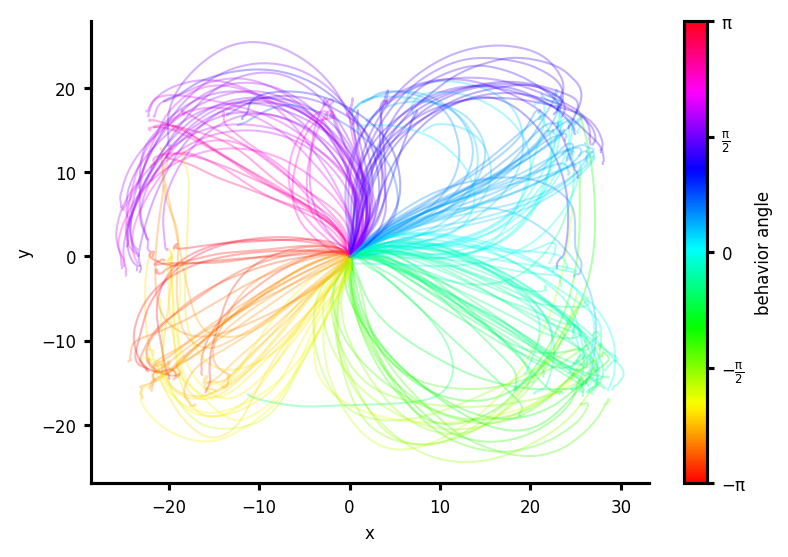

In [10]:
# plot cumulative behavior trajectories colored by angle
# create colormap based on behavior angles (from -pi to pi)
cmap = plt.get_cmap("hsv")
colors = cmap((latent_dataset_train.behavior_angles.squeeze() + np.pi) / (2 * np.pi))
plt.figure(figsize=(6, 4))

# plot trajectories with subsampling for clarity
for i in range(0, len(latent_dataset_train.behavior), 10):
    plt.plot(
        latent_dataset_train.behavior_cumsum[i, 0],
        latent_dataset_train.behavior_cumsum[i, 1],
        color=colors[i],
        alpha=0.3,
    )

# add colorbar with pi-based tick labels
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(-np.pi, np.pi))
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(-np.pi, np.pi, 5), label="behavior angle", ax=plt.gca())
cbar.ax.set_yticklabels([r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
plt.xlabel("x")
plt.ylabel("y")

In [11]:
from ldns.utils import count_parameters

print(count_parameters(denoiser) / 1e6, "M parameters")

denoiser

2.696848 M parameters


ConditionalDenoiser(
  (conv_in): Conv1d(16, 256, kernel_size=(1,), stride=(1,), groups=16)
  (blocks): ModuleList(
    (0-5): 6 x DenoiserBlock(
      (time_mixer): FFTConv(
        (activation): Identity()
        (kernel): SSMKernelDPLR()
        (drop): Identity()
        (drop_kernel): Identity()
      )
      (channel_mixer): Sequential(
        (0): Rearrange('b c l -> b l c')
        (1): Linear(in_features=256, out_features=512, bias=True)
        (2): GELU(approximate='none')
        (3): Linear(in_features=512, out_features=256, bias=True)
        (4): Rearrange('b l c -> b c l')
      )
      (norm1): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (norm2): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (act1): GELU(approximate='none')
      (act2): Identity()
      (ada_ln): Sequential(
        (0): GELU(approximate='none')
        (1): Linear(in_features=64, out_features=1536, bias=Tr

In [12]:
def sample_conditioned_on_angle(
    ema_denoiser,
    scheduler,
    cfg,
    batch_size=1,
    generator=None,
    device="cuda",
    signal_length=None,
    angle=None,
):
    """Sample from the diffusion model conditioned on a specific angle.

    Args:
        ema_denoiser: EMA model for denoising
        scheduler: Diffusion scheduler
        cfg: Config object
        batch_size: Number of samples to generate
        generator: Random number generator
        device: Device to run on
        signal_length: Length of signal to generate
        angle: Conditioning angle in radians. If None, samples randomly.

    Returns:
        Tuple of (generated samples, conditioning angles used)
    """
    if signal_length is None:
        signal_length = cfg.dataset.signal_length

    if angle is None:
        angle = torch.rand(batch_size) * 2 * np.pi - np.pi  # sample uniformly from -pi to pi
        angle_c = angle.unsqueeze(1)
    else:
        # ensure angle is a tensor and has correct shape
        if not isinstance(angle, torch.Tensor):
            angle = torch.tensor([angle], dtype=torch.float32)
        if angle.dim() == 0:
            angle = angle.unsqueeze(0)  # make it 1d if it's a scalar
        angle_c = angle.unsqueeze(1).repeat(batch_size, 1)

    z_t = torch.randn((batch_size, cfg.denoiser_model.C_in, signal_length)).to(device)

    ema_denoiser_avg = ema_denoiser.averaged_model

    scheduler.set_timesteps(cfg.denoiser_model.num_train_timesteps)

    for t in tqdm(scheduler.timesteps, desc="Sampling DDPM"):
        with torch.no_grad():
            model_output = ema_denoiser_avg(
                z_t,
                t=torch.tensor([t] * batch_size).to(device).long(),
                c=torch.cat([torch.cos(angle_c), torch.sin(angle_c)], dim=1),
            )
        z_t = scheduler.step(model_output, t, z_t, generator=generator, return_dict=False)[0]

    return z_t, angle

In [13]:
def gen_rates_and_train_decoded_behavior_conditioned_on_angle(
    ema_denoiser,
    scheduler,
    ae,
    cfg,
    train_latent_dataloader,
    val_latent_dataloader,
    num_samples=100,
    device="cuda",
    angle=None,
):
    """Generate neural rates and train a decoder to predict behavior conditioned on angle.

    Args:
        ema_denoiser: EMA model for denoising
        scheduler: Diffusion scheduler
        ae: Autoencoder model
        cfg: Config object
        train_latent_dataloader: Training data loader
        val_latent_dataloader: Validation data loader
        num_samples: Number of samples to generate
        device: Device to run on
        angle: Optional conditioning angle in radians

    Returns:
        Dict containing predicted and real behaviors for validation and sampled data
    """
    # set models to eval mode
    avg_denoiser = ema_denoiser.averaged_model
    avg_denoiser.eval()
    ae.eval()

    # get training rates and behavior
    train_rates = []
    train_behavior = []
    for batch in train_latent_dataloader:
        signal = batch["signal"]
        behavior = batch["behavior"]
        with torch.no_grad():
            output_rates = ae(signal)[0].cpu()
        train_rates.append(output_rates)
        train_behavior.append(behavior.cpu())

    train_rates = torch.cat(train_rates, 0)  # [B C L]
    train_behavior = torch.cat(train_behavior, 0)  # [B 2 L]
    print(train_rates, train_behavior)

    # get validation rates and behavior
    val_rates = []
    val_behavior = []
    for batch in val_latent_dataloader:
        signal = batch["signal"]
        behavior = batch["behavior"]
        with torch.no_grad():
            output_rates = ae(signal)[0].cpu()
        val_rates.append(output_rates)
        val_behavior.append(behavior.cpu())

    val_rates = torch.cat(val_rates, 0)  # [B C L]
    val_behavior = torch.cat(val_behavior, 0)  # [B 2 L]
    print(val_rates, val_behavior)

    # decode rates to behavior using ridge regression
    from sklearn.linear_model import Ridge
    from sklearn.metrics import r2_score
    from einops import rearrange

    # reshape data for regression
    bs_val = val_rates.shape[0]
    train_rates = rearrange(train_rates, "b c l -> (b l) c").numpy()
    val_rates = rearrange(val_rates, "b c l -> (b l) c").numpy()
    train_behavior = rearrange(train_behavior, "b c l -> (b l) c").numpy()
    val_behavior = rearrange(val_behavior, "b c l -> (b l) c").numpy()

    # fit ridge regression model
    ridge_model = Ridge(alpha=1e-6)
    ridge_model.fit(train_rates, train_behavior)

    # predict on validation set
    predicted_behavior = ridge_model.predict(val_rates)
    r2 = r2_score(val_behavior, predicted_behavior)
    print(f"R2 score on val: {r2:.3f}")

    # generate samples from denoiser
    sampled_latents, angles = sample_conditioned_on_angle(
        ema_denoiser=ema_denoiser,
        scheduler=scheduler,
        cfg=cfg,
        batch_size=num_samples,
        device=device,
        angle=angle,
    )

    # denormalize latents
    sampled_latents = sampled_latents * latent_dataset_train.latent_stds.to(
        sampled_latents.device
    ) + latent_dataset_train.latent_means.to(sampled_latents.device)

    # decode latents to rates
    with torch.no_grad():
        sampled_rates = ae.decode(sampled_latents).cpu()

    # predict behavior from sampled rates
    sampled_rates = rearrange(sampled_rates, "b c l -> (b l) c").numpy()
    predicted_sampled_behavior = ridge_model.predict(sampled_rates)

    # return results dictionary
    return {
        "predicted_val_behavior": rearrange(predicted_behavior, "(b l) c -> b c l", b=bs_val),
        "real_val_behavior": rearrange(val_behavior, "(b l) c -> b c l", b=bs_val),
        "predicted_sampled_behavior": rearrange(predicted_sampled_behavior, "(b l) c -> b c l", b=num_samples),
        "angles": angles,
    }


In [ ]:
# loss function for training
loss_fn = torch.nn.SmoothL1Loss(beta=0.05, reduction="mean")  # faster convergence than mse

# training loop
pbar = tqdm(range(0, cfg.training.num_epochs), desc="epochs")
for epoch in pbar:
    for i, batch in enumerate(train_latent_dataloader):
        optimizer.zero_grad()

        # get batch data
        z = batch["latent"]
        t = torch.randint(0, cfg.denoiser_model.num_train_timesteps, (z.shape[0],), device="cpu").long()

        # create angle condition vector
        c = torch.cat([torch.cos(batch["behavior_angle"]), torch.sin(batch["behavior_angle"])], dim=1)

        # add noise and predict denoised
        noise = torch.randn_like(z)
        noisy_z = scheduler.add_noise(z, noise, t)
        noise_pred = denoiser(noisy_z, t=t, c=c)

        # compute loss and update
        loss = loss_fn(noise, noise_pred)
        accelerator.backward(loss)
        accelerator.clip_grad_norm_(denoiser.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()

        # update progress bar
        if i % 10 == 0:
            pbar.set_postfix({"loss": loss.item(), "lr": lr_scheduler.get_last_lr()[0]})

        ema_model.step(denoiser)

    # evaluation and plotting
    if (epoch) % 100 == 0:
        # flags for different evaluations
        plot_rate_samples = True

        if plot_rate_samples:
            # generate and decode samples
            sampled_latents, angles = sample_conditioned_on_angle(
                ema_denoiser=ema_model,
                scheduler=scheduler,
                cfg=cfg,
                batch_size=2,
                device="cuda",
            )
            sampled_latents = sampled_latents * latent_dataset_train.latent_stds.to(
                sampled_latents.device
            ) + latent_dataset_train.latent_means.to(sampled_latents.device)

            # get real samples for comparison
            real_latents = latent_dataset_train.latents[:2].cuda()
            real_latents = real_latents * latent_dataset_train.latent_stds.to(
                real_latents.device
            ) + latent_dataset_train.latent_means.to(real_latents.device)

            # decode both sampled and real latents
            with torch.no_grad():
                sampled_rates = ae_model.decode(sampled_latents).cpu()
                decoded_rates_from_real_latents = ae_model.decode(real_latents).cpu()

            # plot sampled vs real rates
            fig, ax = plt.subplots(1, 2, figsize=(6, 2))
            im = ax[0].imshow(sampled_rates[0], aspect="auto")
            ax[0].set_title("sampled rates")
            fig.colorbar(im, ax=ax[0], orientation="vertical", fraction=0.046, pad=0.04)

            im = ax[1].imshow(decoded_rates_from_real_latents[0], aspect="auto")
            ax[1].set_title("real rates")
            fig.colorbar(im, ax=ax[1], orientation="vertical", fraction=0.046, pad=0.04)
            fig.tight_layout()
            plt.show()

pbar.close()


In [ ]:
# save model
os.makedirs(f"exp/{cfg.exp_name}", exist_ok=True)

torch.save(accelerator.unwrap_model(ema_model.averaged_model).state_dict(), f"exp/{cfg.exp_name}/model.pt")

with open(f"conf/{cfg.exp_name}.yaml", "w") as f:
    f.write(OmegaConf.to_yaml(cfg))


## Evaluation and plotting

In [ ]:
# load the official checkpoint (optional)

denoiser.load_state_dict(torch.load(f"exp/stored_models/{cfg.exp_name}/model.pt"))

ema_model = EMAModel(denoiser)  # for eval and no grad

In [15]:
import seaborn as sns

# generate rates and decode behavior for different angles
behav_dict = gen_rates_and_train_decoded_behavior_conditioned_on_angle(
    ema_denoiser=ema_model,
    scheduler=scheduler,
    ae=ae_model,
    cfg=cfg,
    train_latent_dataloader=train_latent_dataloader,
    val_latent_dataloader=val_latent_dataloader,
    num_samples=100,
    device="cuda",
)

# extract behavior predictions and ground truth
predicted_val_behavior = behav_dict["predicted_val_behavior"]
real_val_behavior = behav_dict["real_val_behavior"]
predicted_sampled_behavior = behav_dict["predicted_sampled_behavior"]
# get angles and normalize to 0-1 for colormap
angles = behav_dict["angles"].numpy() + np.pi  # shift to 0-2pi
angles = angles / (2 * np.pi)  # normalize to 0-1

# compute cumulative trajectories
predicted_traj = np.cumsum(predicted_val_behavior, axis=-1)
real_traj = np.cumsum(real_val_behavior, axis=-1)
predicted_sampled_traj = np.cumsum(predicted_sampled_behavior, axis=-1)

print(predicted_traj.shape, real_traj.shape, predicted_sampled_traj.shape, angles.shape)


tensor[2008, 182, 140] n=51163840 (0.2Gb) x∈[2.045e-06, 0.890] μ=0.019 σ=0.029 tensor[2008, 2, 140] n=562240 (2.1Mb) x∈[-1.154, 1.215] μ=0.016 σ=0.274
tensor[71, 182, 140] n=1809080 (6.9Mb) x∈[4.661e-06, 0.691] μ=0.019 σ=0.029 tensor[71, 2, 140] n=19880 (78Kb) x∈[-0.935, 0.959] μ=0.006 σ=0.277


/mnt/lustre/work/macke/jkapoor83/conda_envs_dirs/ldns/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.34853e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


R2 score on val: 0.890


Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

(71, 2, 140) (71, 2, 140) (100, 2, 140) (100,)


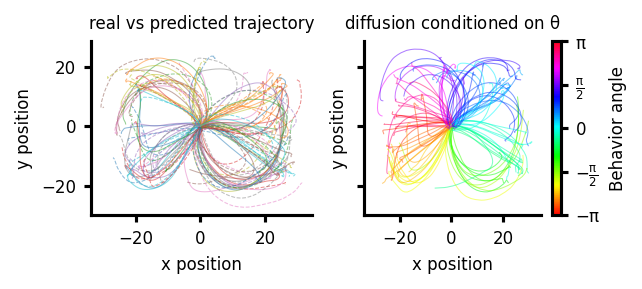

In [16]:
# plot real vs predicted trajectories and diffusion samples conditioned on angle
fig, ax = plt.subplots(1, 2, figsize=cm2inch(11, 5), sharex=True, sharey=True)

# plot real vs predicted trajectories with cycling colors
colors = sns.color_palette("tab10")
for i, idx in enumerate(range(0, 70, 1)):
    # plot real trajectory
    ax[0].plot(
        real_traj[idx, 0, :],
        real_traj[idx, 1, :],
        label="real trajectory",
        color=colors[i % 10],  # cycle through colors
        alpha=0.5,
        lw=0.5,
    )
    # plot predicted trajectory
    ax[0].plot(
        predicted_traj[idx, 0, :],
        predicted_traj[idx, 1, :],
        label="predicted trajectory",
        linestyle="--",
        color=colors[i % 10],
        alpha=0.5,
        lw=0.5,
    )
ax[0].set_xlabel("x position")
ax[0].set_ylabel("y position")
ax[0].set_title("real vs predicted trajectory")

# plot diffusion samples colored by angle
cmap = plt.get_cmap("hsv")
colors = cmap(angles)
for i, idx in enumerate(range(0, 100)):
    ax[1].plot(
        predicted_sampled_traj[idx, 0, :],
        predicted_sampled_traj[idx, 1, :],
        linestyle="-",
        color=colors[i],
        alpha=0.5,
        lw=0.5,
    )

ax[1].set_xlabel("x position")
ax[1].set_ylabel("y position")
ax[1].set_title("diffusion conditioned on $\\theta$")

# add colorbar with angle labels in terms of pi
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(-np.pi, np.pi))
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(-np.pi, np.pi, 5), label="Behavior angle", ax=ax[1])
cbar.ax.set_yticklabels([r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])

# save figure
fig.tight_layout()
